In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm
import json
import os
from get_plot_dict import get_plot_dict
from tqdm import tqdm
warnings.filterwarnings('ignore')
from datequarter import DateQuarter
import datetime

In [2]:
def get_sector_list(df, code2):
    hscode6_list = [x for x in map(str, df['hscode6'].unique()) if x.startswith(code2)]
    hscode6_array = [int(i) for i in hscode6_list]
    return hscode6_array


def get_panjiva():
    """Trae la data pura de PANJIVA
    """
    df = pd.read_csv('portof(un)lading/panjivausimport_imputevalue_shippingtime_yq.csv')
    df = df[['gvkey', 'year', 'quarter', 'hscode6', 'shpcountry', 'valueofgoodsusd_new', 'volumeteu', 'weightkg']]
    df = df[df.year>2008]
    return df


def get_data_aggr(df, sector_list, country_list, aggr_country=[], aggr_country_name='SAC'):
    if(len(aggr_country)>0): 
        df['source'] = np.where(df['shpcountry'].isin(aggr_country), aggr_country_name, 'Other') 
    if(len(aggr_country)==0): 
        df['source'] = 'Other'
        aggr_country = []
    for country in list(set(country_list).difference(set(aggr_country))):
        df.loc[df['shpcountry']==country, 'source'] = country   
    return df


def get_ordered_source(df, output):
    serie = df[['source', output]].groupby(['source']).sum().unstack()
    serie = pd.to_numeric(serie, downcast="integer").sort_values(ascending=False)
    df = pd.DataFrame(serie.reset_index(inplace=False))
    df = df.drop(columns=['level_0'])
    df.columns = ['source', output]
    return df['source']
   

def get_plot(sector_list, country_list, aggr_country, aggr_country_name,
             output='volumeteu', 
             title='Automobile imports', period=["2008-03-01", "2022-03-01"], 
             hp='NO', hp_lambda=100,
             save_as='plot_name',
             figsize=[5, 10]):
    
    df = get_data(sector_list)
    df = get_data_aggr(df, sector_list, country_list, aggr_country, aggr_country_name)
    get_plot_ts(df, output, title, period, hp=hp, hp_lambda=hp_lambda, save_as=save_as, figsize=figsize)


In [3]:
def get_data_continent(df):
    df.loc[list(map(lambda country: country.startswith('Congo'), df['shpcountry'])), 'shpcountry'] = 'Congo'
    df.loc[list(map(lambda country: country.startswith('Micronesia'), df['shpcountry'])), 'shpcountry'] = 'Micronesia'
    df.loc[list(map(lambda country: country.startswith('Moldova'), df['shpcountry'])), 'shpcountry'] = 'Moldova'
    df.loc[list(map(lambda country: country.startswith('Micronesia'), df['shpcountry'])), 'shpcountry'] = 'Micronesia'
    df.loc[list(map(lambda country: country.startswith('Virgin Islands (U.S.)'), df['shpcountry'])), 'shpcountry'] = 'United States Virgin Islands'
    df.loc[list(map(lambda country: country.startswith('Virgin Islands (British)'), df['shpcountry'])), 'shpcountry'] = 'British Virgin Islands'
    df.loc[list(map(lambda country: country.startswith('Samoa'), df['shpcountry'])), 'shpcountry'] = 'Samoa'

    country_continent = pd.read_csv('country_continent.csv')
    df = df.merge(country_continent, left_on='shpcountry', right_on='COUNTRY', how='left', suffixes=None)  
    df['source'] = 'Rest of the World'
    df.loc[(df['CONTINENT'] == 'Asia', 'source')] = 'Rest of Asia'
    df.loc[(df['shpcountry'] == 'China', 'source')] = 'China'
    df.loc[(df['CONTINENT'] == 'Europe', 'source')] = 'Europe'
    return df


In [15]:
f = open('hscode2.json')
hscode2 = json.load(f) 
f.close()

f = open('hscode6.json')
hscode6 = json.load(f) 
f.close()

output='volumeteu'
hscode2['59']

data = pd.DataFrame()
for code2 in ['87','64','85','94','63','62','61','59','95']:
    df = pd.DataFrame({'code2': [code2], 'code2_name': [hscode2[code2]]})
    data = data.append(df)

data.to_csv("code2_names.csv")
data

,code2,code2_name
0,87,Vehicles; other than railway or tramway rollin...
0,64,Footwear; gaiters and the like; parts of such ...
0,85,Electrical machinery and equipment and parts t...
0,94,"Furniture; bedding, mattresses, mattress suppo..."
0,63,"Textiles, made up articles; sets; worn clothin..."
0,62,Apparel and clothing accessories; not knitted ...
0,61,Apparel and clothing accessories; knitted or c...
0,59,"Textile fabrics; impregnated, coated, covered ..."
0,95,"Toys, games and sports requisites; parts and a..."


In [10]:
for code2 in ['59','61','62','63','64','85','87','94','95']:
    print(code2, ' : ', hscode2[code2])

59  :  Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use
61  :  Apparel and clothing accessories; knitted or crocheted
62  :  Apparel and clothing accessories; not knitted or crocheted
63  :  Textiles, made up articles; sets; worn clothing and worn textile articles; rags
64  :  Footwear; gaiters and the like; parts of such articles
85  :  Electrical machinery and equipment and parts thereof; sound recorders and reproducers; television image and sound recorders and reproducers, parts and accessories of such articles
87  :  Vehicles; other than railway or tramway rolling stock, and parts and accessories thereof
94  :  Furniture; bedding, mattresses, mattress supports, cushions and similar stuffed furnishings; lamps and lighting fittings, n.e.s.; illuminated signs, illuminated name
95  :  Toys, games and sports requisites; parts and accessories thereof


In [11]:
df_panjiva = get_panjiva()

In [14]:
df_panjiva.shape

(6285051, 8)

Vehicles; other than railway or tramway rolling stock, and parts and accessories thereof


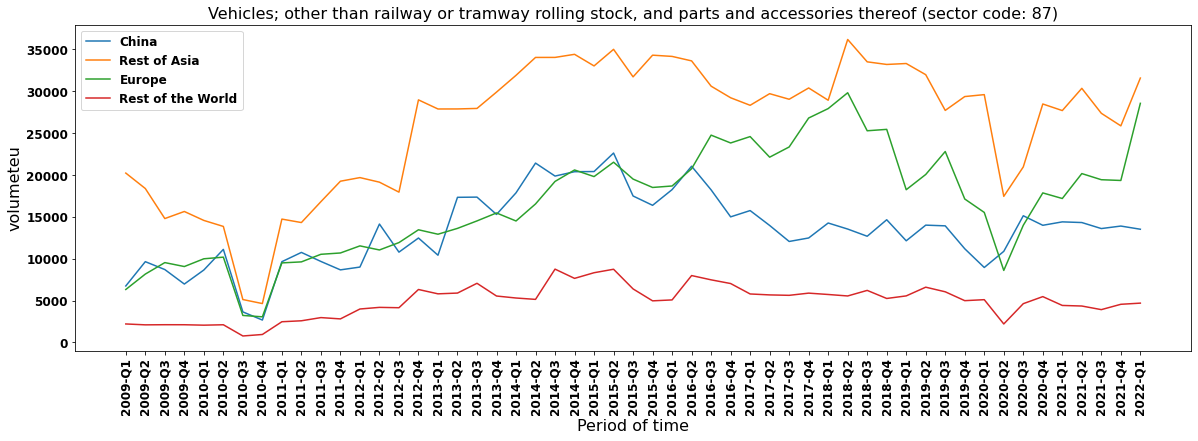

Footwear; gaiters and the like; parts of such articles


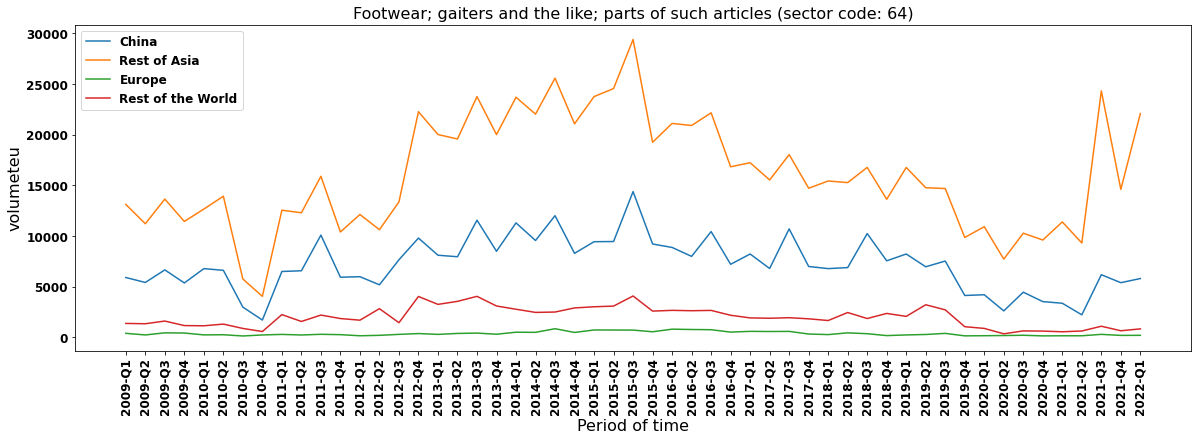

Electrical machinery and equipment and parts thereof


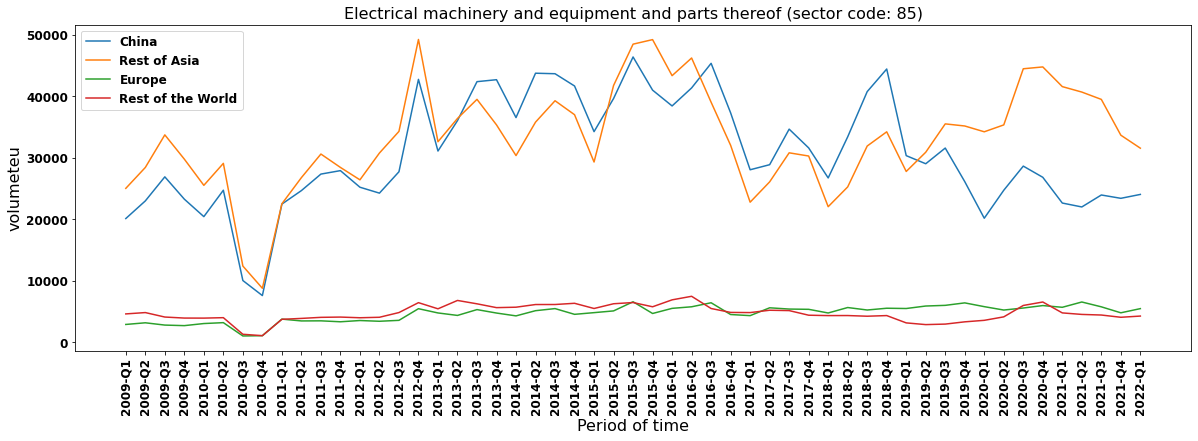

Furniture; bedding, mattresses, mattress supports, cushions and similar stuffed furnishings


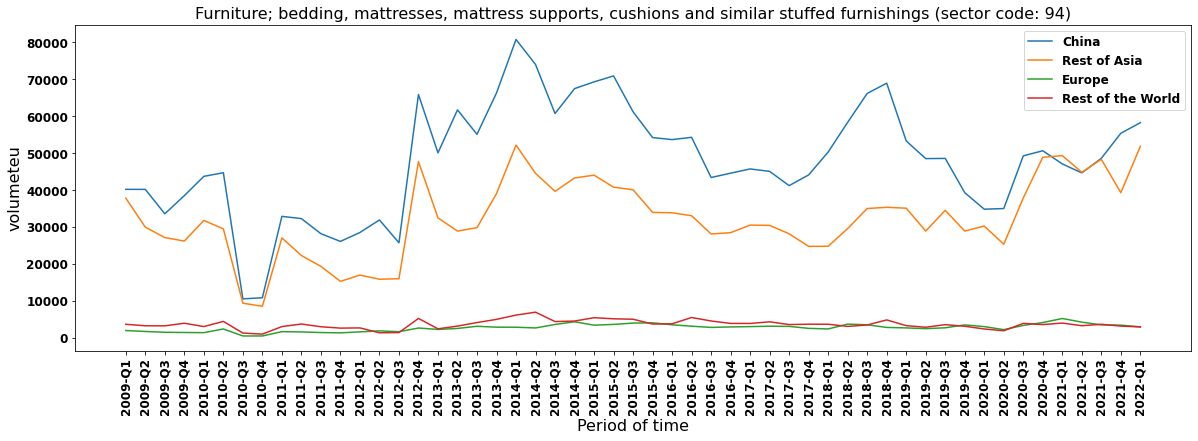

Textiles, made up articles; sets; worn clothing and worn textile articles; rags


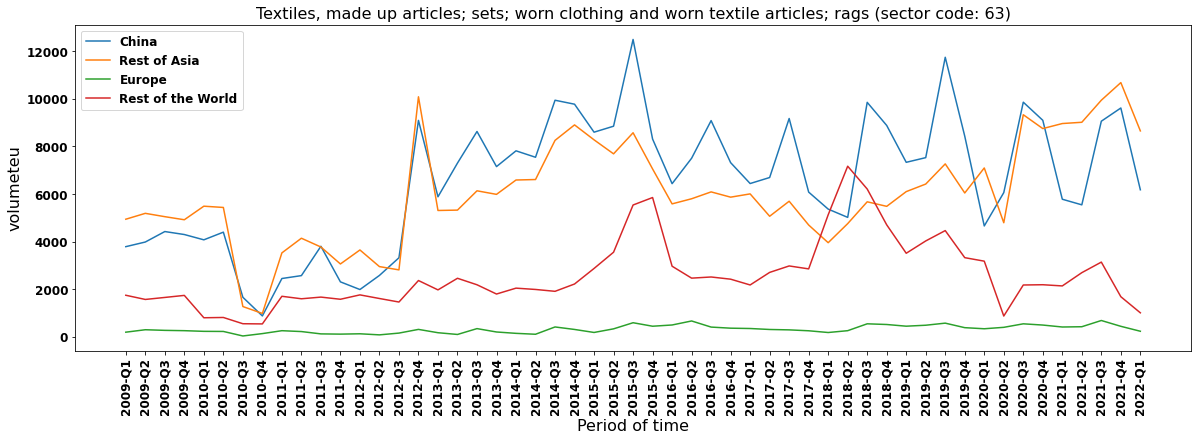

Apparel and clothing accessories; not knitted or crocheted


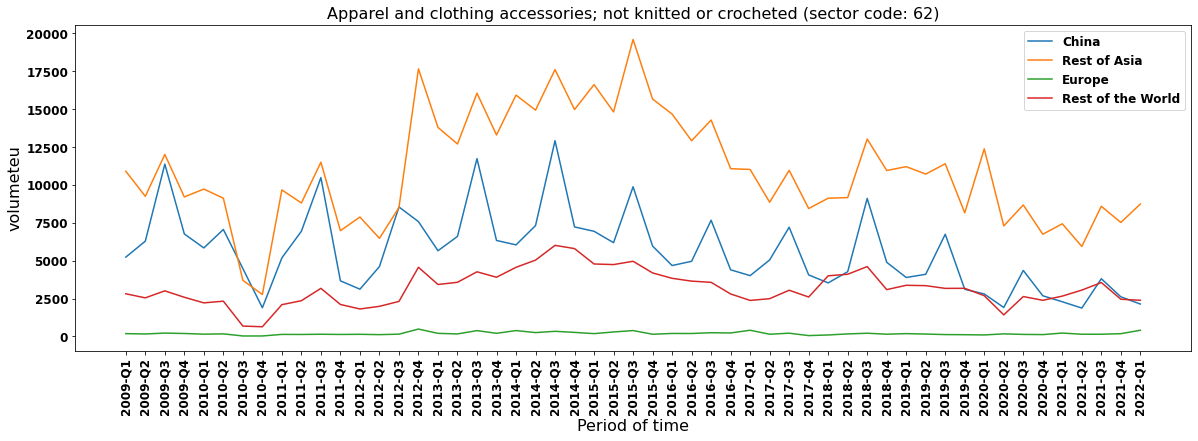

Apparel and clothing accessories; knitted or crocheted


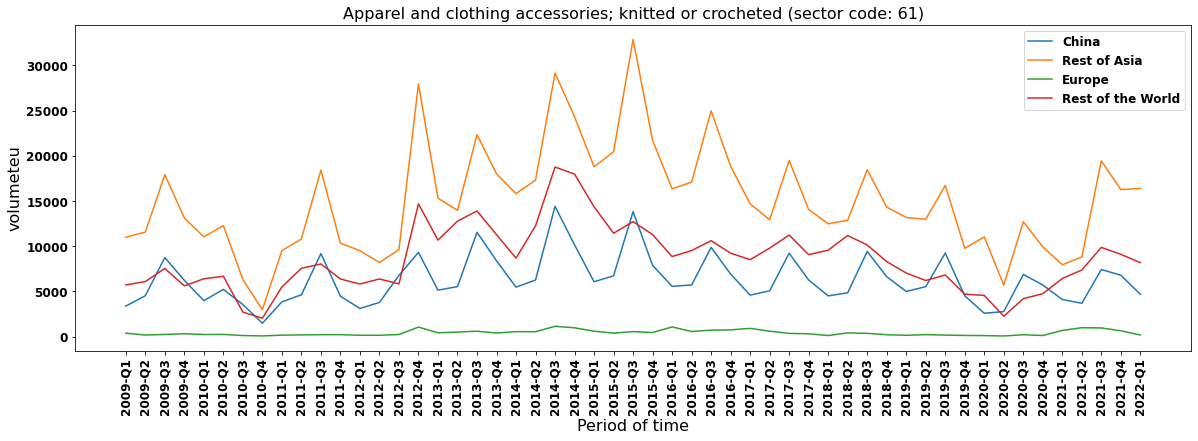

Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use


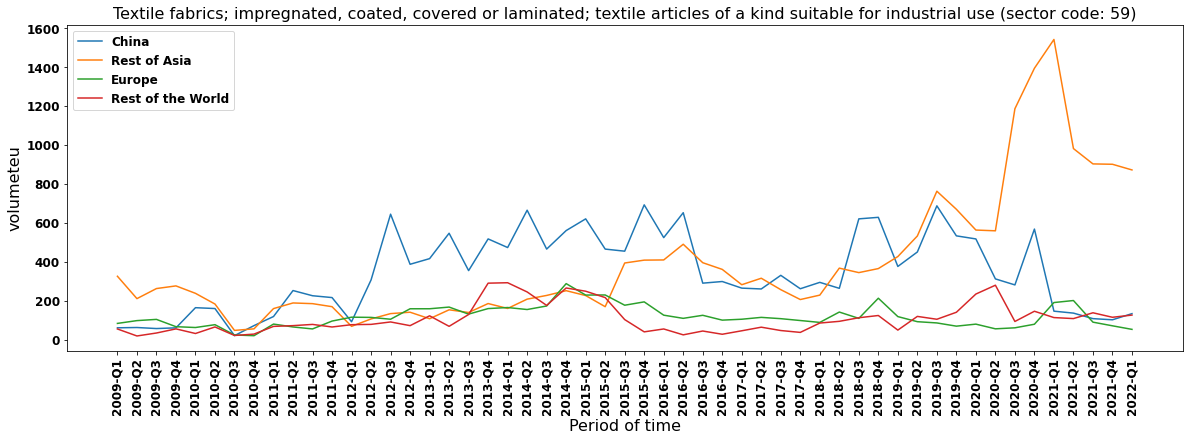

Toys, games and sports requisites; parts and accessories thereof


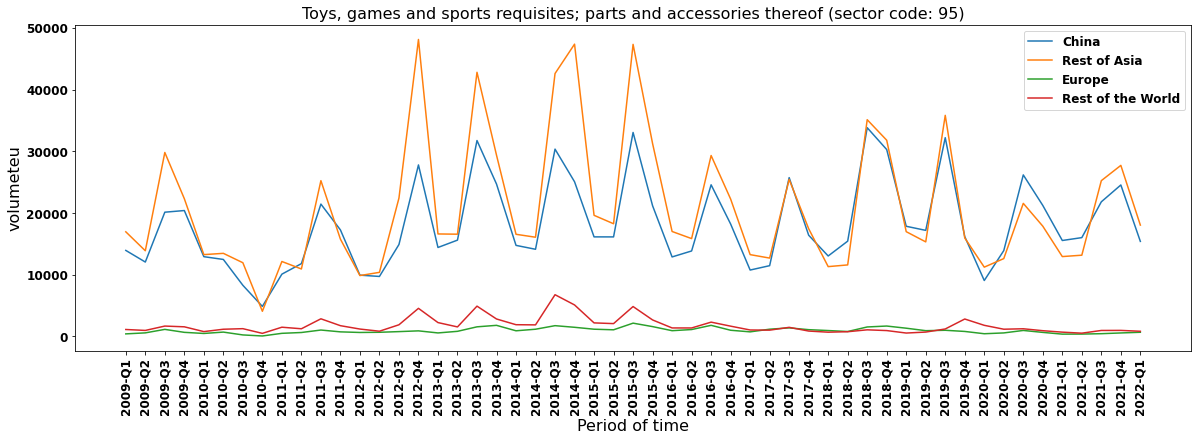

In [53]:
for code2 in ['87','64','85','94','63','62','61','59','95']:
    code2_name = hscode2[code2]
    code6 = get_sector_list(df_panjiva, code2)
    df = get_data_sector(df_panjiva, code6)
    df = get_data_continent(df)

    print(code2_name)
    
    get_plot_ts(df, output='volumeteu', 
                title = code2_name +' (sector code: '+code2+')', 
                period = ['2008-03-01','2022-03-01'], 
                hp = 'NO', hp_lambda = 100, 
                save_as = os.path.join('paper','plots',code2),
                figsize = [6, 20])


In [58]:
data = pd.DataFrame()

for code2 in ['87','64','85','94','63','62','61','59','95']:
    code2_name = hscode2[code2]
    code6 = get_sector_list(df_panjiva, code2)
    df = get_data_sector(df_panjiva, code6)
    df = get_data_continent(df)
    df['code2'] = code2
    
    data = data.append(df)

    print(code2_name)

Vehicles; other than railway or tramway rolling stock, and parts and accessories thereof
Footwear; gaiters and the like; parts of such articles
Electrical machinery and equipment and parts thereof
Furniture; bedding, mattresses, mattress supports, cushions and similar stuffed furnishings
Textiles, made up articles; sets; worn clothing and worn textile articles; rags
Apparel and clothing accessories; not knitted or crocheted
Apparel and clothing accessories; knitted or crocheted
Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use
Toys, games and sports requisites; parts and accessories thereof


In [60]:
data.to_csv('data.csv')

In [61]:
df = pd.read_csv('data2.csv')

# Tariff

In [181]:
def get_data_sector(df, code6):
   
    df['hscode6_str'] = df['hscode6'].astype(str)
    df['hscode4_str'] = df['hscode6_str'].str.slice(stop=3)
    df['hscode4'] = df['hscode4_str'].astype(int)
    
    df = df[df['hscode6'].isin(code6)]
    
    df["qs_"] = list(map(DateQuarter,df["year"],df["quarter"]))
    df['qs'] = df['year'].astype(str) +'-Q'+ df['quarter'].astype(str) 
    df['date'] = pd.PeriodIndex(df['qs'], freq='Q').to_timestamp()
    
    return df

In [192]:
def get_tariff():
    df = pd.read_csv('h6_tariff.csv')
    df = df[['hs6', 'uscn34_tariff_increase', 'uscn16_tariff_increase']]
    df.rename(columns={'hs6': 'hscode6',
                       'uscn34_tariff_increase': 'uscn34',
                       'uscn16_tariff_increase': 'uscn16'}, 
              inplace=True)
    df['uscn'] = df['uscn16'] + df['uscn34']
    df = df[df['uscn']>0]
    df.drop(columns=['uscn16', 'uscn34'], inplace=True)
    df = df[df['hscode6'].isin(code6)]
    
    return df

In [207]:
def get_plot_ts(df, output, title, period, hp='NO', hp_lambda=100, 
                save_as='plot_name', figsize=[5, 10]):
    
    sources = ['China', 'Rest of Asia', 'Europe', 'Rest of the World']
    
    df = df[['date', 'year', 'quarter', 'qs', 'qs_', 'source', output]].groupby(['date', 'year', 'quarter', 'qs', 'qs_', 'source']).sum().unstack()
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    
    # generate date as Quartil
    df['fecha'] = pd.to_datetime(df['date'], format ='%Y-%m-%d') 
    df = df.drop('date', axis=1)
    df['month'] = pd.DatetimeIndex(df['fecha']).month
    df.loc[df['month']==1, 'month'] = 3
    df.loc[df['month']==4, 'month'] = 6
    df.loc[df['month']==7, 'month'] = 9
    df.loc[df['month']==10, 'month'] = 12
    df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
    df = df.drop(['fecha', 'year', 'month', 'quarter'], axis=1)
    
    df = df[df.date>=period[0]]
    df = df[df.date<=period[1]]

    fig = plt.figure() 
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])


    # chn60b_tariff_increase1	20180918
    # chn60b_tariff_increase2	20190513
    plt.axvline(datetime.date(2018, 9, 18), color="red", linestyle="dashed", 
                label='chn60b tariff increase1')    
  
    for source in sources:        
        if hp=='NO':
            serie = np.array(df[source]).astype(np.double)
            mask = np.isfinite(serie)
            plt.plot(df["qs"][mask], serie[mask], label=source)
        if hp=='YES':
            cycle, trend = sm.tsa.filters.hpfilter(df[source], hp_lambda)
            df[source+'_hp'] = trend
            serie = np.array(df[source+'hp']).astype(np.double)
            mask = np.isfinite(serie)
            plt.plot(df["qs"][mask], serie[mask], label=source)
        
    plt.title(title)
    plt.ylabel(output)
    plt.xlabel("Period of time")
    plt.xticks(df["qs"], rotation='vertical')          

    plt.legend()
    
    plt.rc('font', size=12)
    plt.rc('axes', titlesize=16)
    plt.rc('axes', labelsize=16)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('legend', fontsize=12)
    plt.rc('figure', titlesize=20)
    
    plt.savefig(save_as + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [209]:
df = get_tariff()
code6 = df['hscode6']
df = get_data_sector(df_panjiva, code6)
df = get_data_continent(df)

In [214]:
for code2 in ['87','64','85','94','63','62','61','59','95']:
    code2_name = hscode2[code2]
    code6 = get_sector_list(df_panjiva, code2)
    df = get_data_sector(df_panjiva, code6)
    df = get_data_continent(df)
    df['code2'] = code2
    df.to_csv('df_' + code2 + '.csv')
    print(code2_name)

Vehicles; other than railway or tramway rolling stock, and parts and accessories thereof
Footwear; gaiters and the like; parts of such articles
Electrical machinery and equipment and parts thereof
Furniture; bedding, mattresses, mattress supports, cushions and similar stuffed furnishings
Textiles, made up articles; sets; worn clothing and worn textile articles; rags
Apparel and clothing accessories; not knitted or crocheted
Apparel and clothing accessories; knitted or crocheted
Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use
Toys, games and sports requisites; parts and accessories thereof


In [62]:
# elimina duplicados: firm, shipcountry, product, date
for code2 in ['87','64','85','94','63','62','61','59','95']:
    print(code2)
    df = pd.read_csv('df_' + code2 + '.csv')
    df = df[['gvkey', 'hscode6_str', 'date', 'COUNTRY', 'CONTINENT', 'volumeteu', 'weightkg']]
    df = df.groupby(['gvkey', 'hscode6_str', 'date', 'COUNTRY', 'CONTINENT']).sum() 
    df.reset_index(inplace=True)
    df.to_csv('df_' + code2 + '.csv')

87
64
85
94
63
62
61
59
95


In [40]:
code2 = '85'
df = pd.read_csv('df_' + code2 + '.csv')

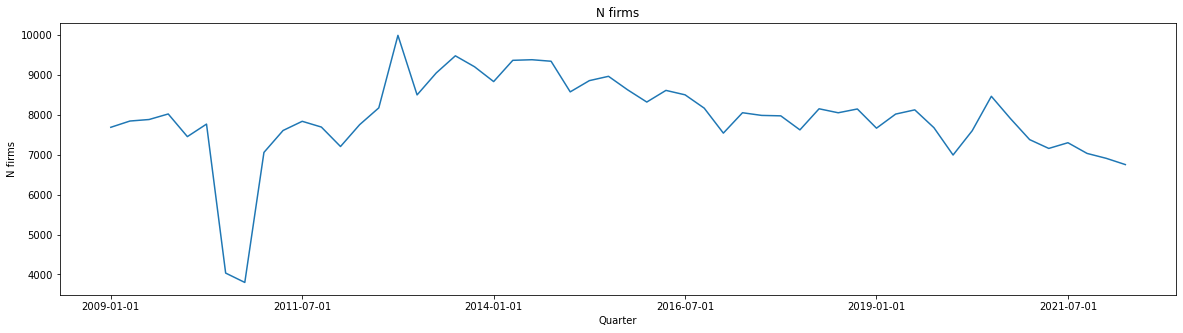

In [18]:
df.groupby(['date'])['gvkey'].count().plot(kind='line', figsize=(20,5))
plt.title("N firms")
plt.ylabel("N firms")
plt.xlabel("Quarter");

In [12]:
def plot_source(df):
    df = df.groupby(['date', 'gvkey', 'hscode6_str'])['gvkey'].count()
    df = df.to_frame()
    df = df.rename(columns={"gvkey": "count"})
    df.reset_index(inplace=True)

    df.groupby(['date'])['count'].sum().plot(kind='line', figsize=(20,5))
    plt.title("N sources")
    plt.ylabel("N sources")
    plt.xlabel("Quarter");

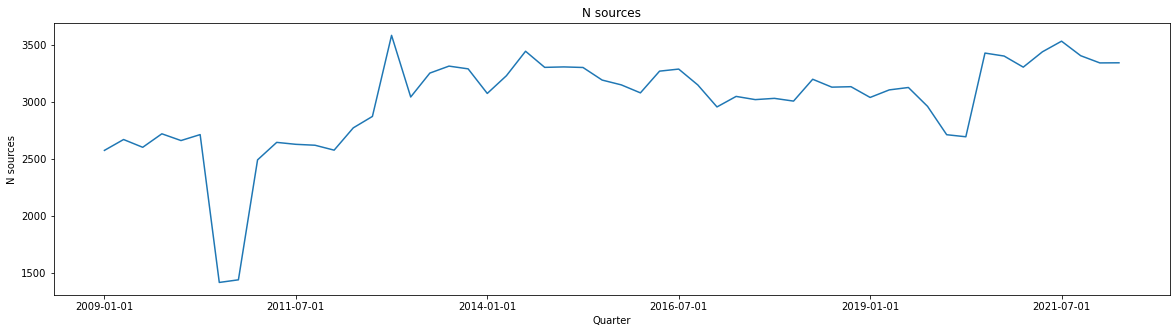

In [13]:
plot_source(df)

In [117]:
def plot_source2(df):
    df = df.groupby(['date', 'gvkey', 'hscode6_str'])['gvkey'].count()
    df = df.to_frame()
    df = df.rename(columns={"gvkey": "count"})
    df.reset_index(inplace=True)
    
    df['count2'] = np.where(df['count']>1, 1, 0)
    
    df = df.groupby(['date'])['count2'].sum().plot(kind='line', figsize=(20,5))
    plt.title("N sources (>1)")
    plt.ylabel("N sources (>1)")
    plt.xlabel("Quarter");

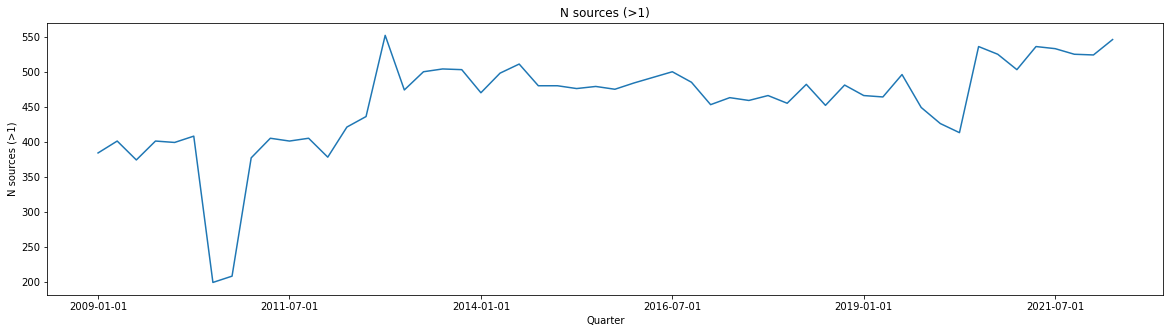

In [118]:
plot_source2(df)

In [9]:
def df_firms_product(df):
    df = df.groupby(['gvkey', 'hscode6_str'])['gvkey'].count()
    df = df.to_frame()
    df = df.rename(columns={"gvkey": "count"})
    df.reset_index(inplace=True)
    
    return df

In [72]:
code2 = '85'
df = pd.read_csv('df_' + code2 + '_.csv')

In [73]:
df

,gvkey,hscode6_str,date,vol_asia,vol_china,vol_europe,vol_world,year,quarter,icaptq,...,vol_world_perc,vol_china_perc_lag,vol_china_perc_gr,id_vol_china_perc_gr,vol_asia_perc_lag,vol_asia_perc_gr,id_vol_asia_perc_gr,vol_europe_perc_lag,vol_europe_perc_gr,id_vol_europe_perc_gr
0,1004,850220,2021q2,0.0,1260.0,0.0,0.0,2021,2,1168.000,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
1,1004,850990,2013q3,700.0,0.0,0.0,0.0,2013,4,1554.800,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
2,1004,851650,2012q3,0.0,0.0,0.0,41290.0,2012,3,1561.500,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
3,1013,850440,2014q2,0.0,0.0,1.0,0.0,2014,1,NaN,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
4,1013,850511,2020q2,0.0,0.0,17661.0,0.0,2020,1,NaN,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322972,345920,854442,2017q4,0.0,12034.0,0.0,0.0,2017,2,NaN,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
322973,345920,854442,2018q2,0.0,13982.0,0.0,0.0,2018,2,NaN,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
322974,345920,854442,2020q1,0.0,14838.0,0.0,0.0,2020,1,NaN,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
322975,345920,854442,2020q3,0.0,5178.0,0.0,0.0,2020,1,125.213,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0


In [70]:
def df_firms_source_date(df):
    df = df.groupby(['gvkey', 'date', 'SOURCE'])['weightkg'].sum()
    df = df.to_frame()
    df.reset_index(inplace=True)
    
    df = df.pivot_table(index=['gvkey', 'SOURCE'], columns='date', values='weightkg', fill_value=0, 
                 aggfunc=lambda x: round(sum(x)/sum(df['weightkg'])*100, 2))
#     df = df.fillna(0)
    return df

In [71]:
df_firms_source_date(df)

KeyboardInterrupt: 

In [ ]:
# pivot_table = pd.pivot_table(df, 
#                              values='weightkg',
#                              index='salesperson',
#                              columns='product',
#                              fill_value=0, aggfunc=lambda x: round(sum(x)/sum(df['weightkg'])*100, 2))

In [75]:
df

,Unnamed: 0,gvkey,hscode6_str,date,COUNTRY,CONTINENT,volumeteu,weightkg
0,0,1004,870323,2016-10-01,Malawi,Africa,2.00,870.0
1,1,1004,870829,2022-01-01,United Arab Emirates,Asia,7.00,29490.0
2,2,1004,870830,2018-01-01,Singapore,Asia,4.00,13282.0
3,3,1004,870899,2009-04-01,Germany,Europe,1.00,986.0
4,4,1004,870899,2009-10-01,Germany,Europe,1.00,1396.0
...,...,...,...,...,...,...,...,...
161972,161972,328795,870899,2009-01-01,United Kingdom,Europe,0.02,170.0
161973,161973,328795,871690,2021-01-01,China,Asia,1.00,17166.0
161974,161974,345920,870870,2014-01-01,Hong Kong,Asia,2.00,4864.0
161975,161975,345920,870892,2010-04-01,China,Asia,1.00,17084.0
